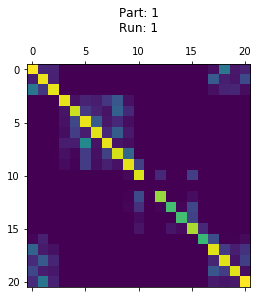

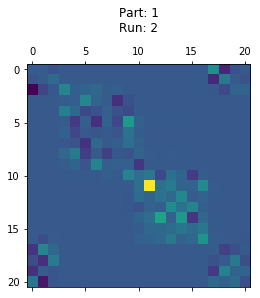

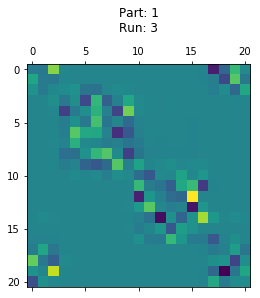

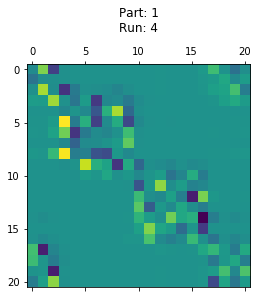

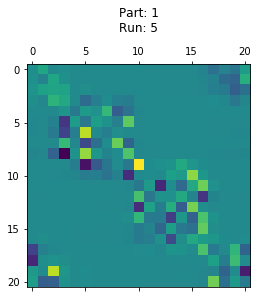

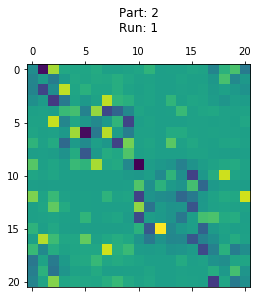

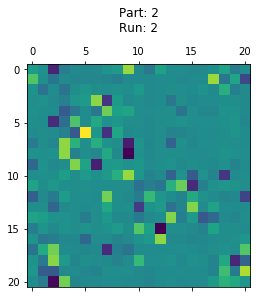

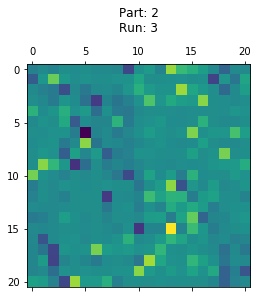

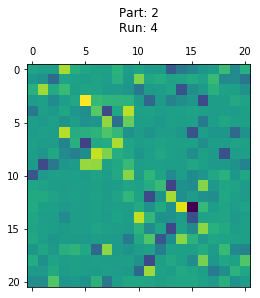

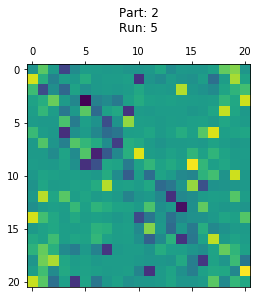

In [4]:
import pandas
import csv
import matplotlib.pyplot as plt
import learn
import util
import numpy as np

gamma = alpha = .5


# makes the envstep necessary for learn.py
def make_envstep (directory):
    envstep = []
    objects = util.get_objects (directory)
    for index in range (len (objects)):
        obj = objects.iat[index,0]
        try:
            envstep.append (int(obj))
        except:
            pass
    return envstep

def main (option):
    
    # This loop adds the address, part number and run number to the runs array, so that the object
    #     sequence in each run can be inputted to the learning agent.
    runs = []
    directory = '/Users/Zhonghou/Desktop/General/Preston Lab/tesser_successor/tesserScan_100_B/'
    for part_num in [1,2]:
        for run_num in [1,2,3,4,5]:
            filename = 'tesserScan_100_B_StructLearn_Part%s_Run_%s.txt'%(part_num, run_num)
            runs.append ([directory+filename, part_num, run_num])
    
    # This option allows the SR matrix to persist across all runs from Part 1 and Part 2
    #     without ever resetting.
    if option == 'persist':
        M = np.zeros([21,21])
        for run in runs:
            part_num, run_num = run[1], run[2]
            envstep = make_envstep (run[0])
            M = learn.run_experiment(envstep, gamma, alpha, M)
            plt.matshow (M)
            plt.title('Part: '+str(part_num)+'\nRun: '+str(run_num)+'\n' )
            
    # This option allows the SR matrix to persist in Part 1 and Part 2, but resets it between them.
    if option == 'reset':
        M = np.zeros ([21,21])
        is_reset = False
        for run in runs:
            part_num, run_num = run[1], run[2]
            if not is_reset and part_num == 2:
                M = np.zeros ([21,21])
                is_reset = True
            envstep = make_envstep (run[0])
            M = learn.run_experiment(envstep, gamma, alpha, M)
            plt.matshow (M)
            plt.title('Part: '+str(part_num)+'\nRun: '+str(run_num)+'\n' )
    
    # This option resets the SR matrix between each run.
    if option == 'independent':
        for run in runs:
            part_num, run_num = run[1], run[2]
            M = np.zeros([21,21])
            envstep = make_envstep (run[0])
            M = learn.run_experiment(envstep, gamma, alpha, M)
            plt.matshow (M)
            plt.title('Part: '+str(part_num)+'\nRun: '+str(run_num)+'\n' )

    # This option forces the SR matrix to persist across all runs, but instead of plotting the SR matrix
    #     after each run, it plots the changes made to it after learning each object sequence.
    if option == 'track changes':
        M = np.zeros([21,21])
        for run in runs:
            part_num, run_num = run[1], run[2]
            envstep = make_envstep (run[0])
            M_new = np.copy(M)
            M_new = learn.run_experiment(envstep, gamma, alpha, M_new)
            plt.matshow (M_new-M)
            plt.title('Part: '+str(part_num)+'\nRun: '+str(run_num)+'\n' )
            M = M_new

# Modify the option in the following call to the main function in order to visualize the desired learning
#     sequence.
main('track changes')